<b>Project</b>: Population segmentation and transition probability estimation using data on health and health-related social service needs from the US Health and Retirement Study <br>
<b>Project section</b>: Population segmentation <br>
<b>Python version</b>: 3.9.7 <br>
<b>File name</b>: 04_Survival_Analysis.ipynb <br>
<b>Data required</b>: data_GI_CF.csv <br>
<b>Outcome</b>: Performs Kaplan Meier survival analysis and Cox Regression analysis on mortality on GI segments and CF status <br>
<b>Author</b>: Lize Duminy<br>
<b>Date</b>: 2024.02.03 

# Instructions for use

1. This script requires the dataset __data_GI_CF.csv__, generated by running __03_Complicating_Factors.ipynb__.
2. To execute this script, replace the filepath of the variable __global_path__ in the code below (currently _C:/Users/lize.duminy/data/HRS/data/_) with the filepath of your designated folder for raw data in section __1.1. USER INPUT REQUIRED: Replace this filepath with the filepath of your designated folder for raw data__ below. 

# 1. Praparation

#### Import packages

In [29]:
from lifelines import KaplanMeierFitter # for survival analysis
from lifelines import CoxPHFitter # for survival analysis
from lifelines.plotting import add_at_risk_counts
import pandas as pd # for dealing with dataframes
import numpy as np # for numerical calculations
import random
import os
import os.path
import matplotlib.pyplot as plt 

### 1.1. USER INPUT REQUIRED: Replace this filepath with the filepath of your designated folder for data

In [30]:
#Filepath for data
global_path=os.path.join("C:/Users/lize.duminy/data/HRS/data/")
print(global_path)

#Filepath for Kaplan-Meier survival curves
km_path=os.path.join("C:/Users/lize.duminy/data/HRS/02_results/01_KaplanMeier/")
#km_path=os.path.join("")
print(km_path)

#Filepath for Cox regression analysis on mortality
cr_path=os.path.join("C:/Users/lize.duminy/data/HRS/02_results/02_CoxRegression/")
#cr_path=os.path.join("")
print(cr_path)

C:/Users/lize.duminy/data/HRS/data/
C:/Users/lize.duminy/data/HRS/02_results/01_KaplanMeier/
C:/Users/lize.duminy/data/HRS/02_results/02_CoxRegression/


### 1.2. Load data

#### Load "data_GI_CF.csv"

In [31]:
filepath = os.path.join(global_path , "data_GI_CF.csv")
data = pd.read_csv(filepath)
print(data.shape)

(61818, 166)


C:\Users\lize.duminy\AppData\Local\Temp\ipykernel_17912\3041331522.py:2: DtypeWarning: Columns (3,4,5,7,8,9,14,15,16,17,18,19,20,21,22,23,24,32,33,34,35,144) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(filepath)


#### Load "data.csv"

In [32]:
filepath0 = os.path.join(global_path , "dataHRS.csv")
data0 = pd.read_csv(filepath0)
print(data0.shape)

(61818, 96)


# 2. Kaplan-Meier survival curves of mortality 

## 2.1. Prepare data

#### Reduce and sort data

In [33]:
#Remove unnecessary rows and columns 
data0 = data0.loc[(data0.wave>=8)&(data0.wave<=14),
                  ['hhidpn', 'alive', 'wave', 'iwmonth', 'iwyear', 
                   'knowndeceasedmo', 'knowndeceasedyr', 'birthmo', 'birthyr']]

# Sort data by ID and wave
data = data.sort_values(["hhidpn", "wave"])
data0 = data0.sort_values(["hhidpn", "wave"])


#### Drop respondents that were not allocated a GI segment in wave 8 

In [34]:
#Identify hhidpn numbers interviewed in wave 8
selected = data.loc[(data.wave==8)&(data.GI>=1),'hhidpn']

#Create variable that indicates whether specific hhidpn was 
#interviewed in wave 8 across all waves
selected = np.array(selected)
hhidpn = np.array(data0['hhidpn'])
selected = np.isin(hhidpn, selected)

#Reduce dataframe to contain only selected variables
data0 = data0[selected]

print("Number of respondents per wave:")
data0.wave.value_counts().sort_index()

Number of respondents per wave:


wave
8     7158
9      339
10    5646
11     390
12    4814
13     527
14    3359
Name: count, dtype: int64

### Identify necessary datapoints from initial interview

#### Create a dataframe with GI, CFs and initial interview dates

In [35]:
#Identify GI and CF state at first wave
data_init = data.loc[(data.wave==8)&(data.GI>=1),
                     ['hhidpn','GI','CF', 'fun_assess', 'nrs_rhab', 
                      'disrupt', 'freq_trans', 'polypharm', 'iwmonth', 
                      'iwyear', 'birthmo', 'birthyr', 'gender']]

#Rename variables
data_init.rename(columns = {'GI':'init_GI'}, inplace = True)
data_init.rename(columns = {'CF':'init_CF'}, inplace = True)

### Calculate t_init: time of initial interview (wave 8)

In [36]:
#calculate the initial interview time (t_init)
data_init['t_init'] = (data_init.iwmonth-1)/12 + data_init.iwyear

data_init['age'] = data_init.t_init - (data.birthyr + (data.birthmo-1)/12)

#Restrict data_init to the necessary columns
data_init = data_init[['hhidpn', 'init_GI','init_CF', 't_init', 'fun_assess', 
                       'nrs_rhab', 'disrupt', 'freq_trans', 'polypharm', 
                       'age', 'gender']]

#Number of entries with no initial interview date
print("Number of entries with no initial interview date (t_init):")
x = data_init.hhidpn.value_counts().sum() - data_init.t_init.value_counts().sum()
print(x)

Number of entries with no initial interview date (t_init):
0


### Identify necessary datapoints from final interview

#### Create a dataframe with the final wave of each hhidpn, including the time of last interview 

In [37]:
#Find the last available record of each hhidpn
data_fin = data0.groupby('hhidpn')[['wave']].last()
data_fin = data_fin.reset_index()

#rename wave to specify that it is the final wave individual participated in
data_fin.rename(columns = {'wave':'wave_fin'}, inplace = True)

#merge "wave_fin" to data0 
data_fin = pd.merge(data0, data_fin, how="left", on=["hhidpn"])

#Reduce rows to only include the entries related to the final entry per hhidpn
data_fin = data_fin.loc[(data_fin.wave == data_fin.wave_fin)]

#Rename "alive" to indicate whether individual is dead or alive in the 
#final wave or observation
data_fin.rename(columns = {'alive':'alive_fin'}, inplace = True)

data_fin = data_fin[['hhidpn', 'wave_fin', 'alive_fin', 'iwmonth', 'iwyear', 
                     'knowndeceasedmo', 'knowndeceasedyr']]

#### Calculate t_iw: time of last interview

In [38]:
data_fin['t_iw'] = (data_fin.iwmonth-1)/12 + data_fin.iwyear

#Number of entries with no "last interview" date
print("Number of entries with no last interview date (t_iw):")
x = data_fin.hhidpn.value_counts().sum() - data_fin.t_iw.value_counts().sum()
print(x)

Number of entries with no last interview date (t_iw):
309


### Identify necessary datapoints from last alive interview

#### Create a dataframe with the final alive wave of each hhidpn

In [39]:
#Find the last available record of hhidpn being alive
data_la = data0[data0.alive==1]
data_la = data_la.groupby('hhidpn')[['iwmonth', 'iwyear']].last()
data_la = data_la.reset_index()


data_la.rename(columns = {'iwmonth':'la_iwmonth'}, inplace = True)
data_la.rename(columns = {'iwyear':'la_iwyear'}, inplace = True)


#### Calculate t_la: time of last alive interview

In [40]:
data_la['t_la'] = (data_la.la_iwmonth-1)/12 + data_la.la_iwyear

#Number of entries with no "last alive interview" date
print("Number of entries with no last alive interview date (t_la):")
x = data_la.hhidpn.value_counts().sum() - data_la.t_la.value_counts().sum()
print(x)

Number of entries with no last alive interview date (t_la):
0


### Merge dataframes data_fin and data_la

In [41]:
#Merge data on final record and last alive record
data_fin = pd.merge(data_fin, data_la, how="left", on=["hhidpn"])

### Assign mean interview time per wave to entries with no final interview time (t_iw)

In [42]:
#Assign the mean interview date per wave to individuals with missing dates

#isolate variables of interest from data0
data_iw_m = data0[['wave', 'iwmonth', 'iwyear']]
data_iw_m = pd.DataFrame(data_iw_m)

#Calculate date of interview per entry
data_iw_m['t_iw'] = (data_iw_m.iwmonth-1)/12 + data_iw_m.iwyear

#Calculate the mean interview date per wave
data_iw_m = data_iw_m.groupby('wave')[['t_iw']].mean()
data_iw_m = data_iw_m.reset_index()

#rename variable
data_iw_m.rename(columns = {'t_iw':'t_iw_mean'}, inplace = True)
data_iw_m.rename(columns = {'wave':'wave_fin'}, inplace = True)

#Insert mean interview date per wave to data_fin
data_fin = pd.merge(data_fin, data_iw_m, how="left", on=["wave_fin"])
data_fin.loc[pd.isnull(data_fin.t_iw), 't_iw'] = data_fin.t_iw_mean

#Number of entries with no "last interview" date
print("Number of entries with no last interview date (t_iw):")
x = (data_fin.hhidpn.value_counts().sum() - 
     data_fin.t_iw.value_counts().sum())
print(x)


Number of entries with no last interview date (t_iw):
0


In [43]:
data_fin['t_d'] = (data_fin.knowndeceasedmo-1)/12 + data_fin.knowndeceasedyr

data_fin['test1'] = data_fin.knowndeceasedmo == 98
data_fin['test2'] = data_fin.knowndeceasedyr < data_fin.la_iwyear

data_fin['t_d_min'] = data_fin.t_la
data_fin.loc[(data_fin.t_la < data_fin.knowndeceasedyr), 
             't_d_min'] = data_fin.knowndeceasedyr
data_fin['t_d_max'] = 11/12+data_fin.knowndeceasedyr
data_fin.loc[(data_fin.knowndeceasedmo == 98), 
             't_d'] = random.uniform(data_fin.t_d_min, data_fin.t_d_max)

data_fin.loc[(data_fin.t_la < data_fin.knowndeceasedyr), 
             't_d'] = random.uniform(data_fin.t_la, data_fin.t_iw)


In [44]:
#are there individuals with a t_d who were never assigned alive==5?
print("Number of individuals with a death date (t_d), ",
      "with no exit interview (alive==5):")
print(len(data_fin[(data_fin.alive_fin != 5)&(data_fin.t_d > 0)]))

Number of individuals with a death date (t_d),  with no exit interview (alive==5):
451


In [45]:
#are there and deceased individuals without a t_d?
print("Number of individuals who are known to be deceased ",
      "without a death date (t_d):")
x = (data_fin.alive_fin == 5)&pd.isnull(data_fin.t_d)
print(len(data_fin[x]))

Number of individuals who are known to be deceased  without a death date (t_d):
0


In [46]:
#Calculate an assumed death date as a random date between last live 
#interview and the date of exit interview
data_fin.loc[(data_fin.alive_fin == 5)&pd.isnull(data_fin.t_d), 
             't_d'] = random.uniform(data_fin.t_la, data_fin.t_iw)

#are there and deceased individuals without a t_d?
print("Number of individuals who are known to be deceased without ",
      "a death date (t_d):")
x = (data_fin.alive_fin == 5)&pd.isnull(data_fin.t_d)
print(len(data_fin[x]))

Number of individuals who are known to be deceased without  a death date (t_d):
0


In [47]:
#Create variable showing the date of contact: t_fin

#Assign all entries the most recent interview date
data_fin['t_fin'] = data_fin.t_iw

#For those entries who are deceased, change the date to the death date
data_fin.loc[data_fin.t_d > 0, 't_fin'] = data_fin.t_d

#determine if dead or alive
data_fin['event'] = np.nan
data_fin.loc[data_fin.alive_fin == 1, 'event'] = 0 ###alive
data_fin.loc[data_fin.alive_fin == 5, 'event'] = 1 ###deceased

data_fin.wave_fin.value_counts()

wave_fin
14    3359
12    1390
10     814
13     527
11     390
8      339
9      339
Name: count, dtype: int64

In [48]:
#Merge data regarding the initial and final observation in a single row
data = pd.merge(data_init, data_fin, how="left", on=["hhidpn"])

data['time'] = data.t_fin - data.t_init

data.loc[data.time < 0, 'time'] = data.t_iw - data.t_init

data = data[['hhidpn', 'init_GI', 'init_CF', 'fun_assess', 'nrs_rhab', 'disrupt', 
             'freq_trans', 'polypharm', 'event', 'time', 'age', 'gender']]

In [49]:
print("Number of individuals experiencing event compared to those who do not:")
print(data.event.value_counts().sort_index())

Number of individuals experiencing event compared to those who do not:
event
0.0    4557
1.0    2601
Name: count, dtype: int64


In [50]:
print(data.init_GI.value_counts().sort_index())

init_GI
1.0     816
2.0    1387
3.0    3114
4.0     613
5.0    1228
Name: count, dtype: int64


## 2.2. Model fitting

### GI segments

C:\Users\lize.duminy\AppData\Local\Temp\ipykernel_17912\4129441529.py:37: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


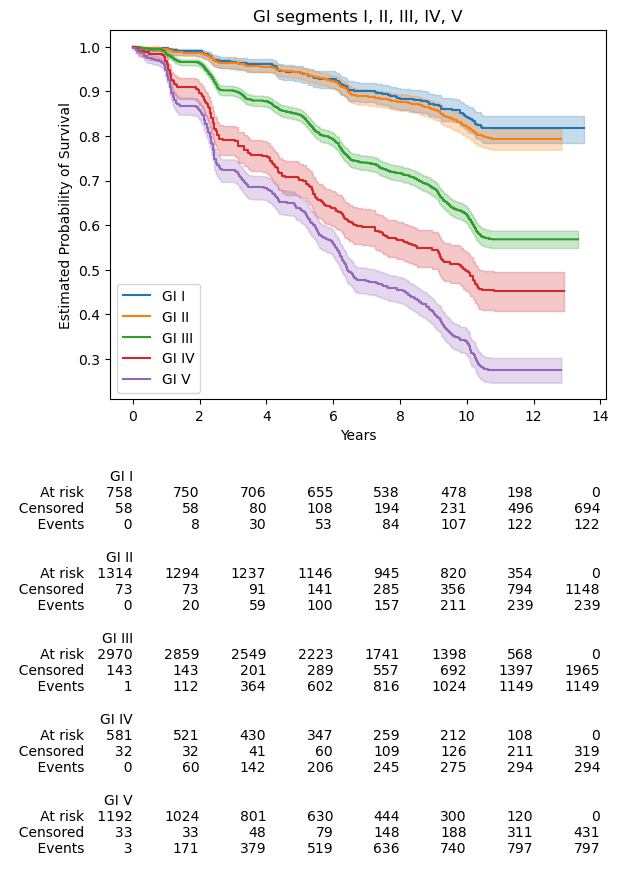

In [51]:
####GI segments  
GI_I = data.init_GI==1      ## GI == 1 at wave 8
GI_II = data.init_GI==2      ## GI == 2 at wave 8
GI_III = data.init_GI==3      ## GI == 3 at wave 8
GI_IV = data.init_GI==4      ## GI == 4 at wave 8
GI_V = data.init_GI==5      ## GI == 5 at wave 8

a1 = plt.subplot(111)

## fit the model for GI I
kmf_I = KaplanMeierFitter() ## instantiate the class to create an object
a1 = kmf_I.fit(data.time[GI_I], data.event[GI_I], label='GI I').plot_survival_function(ax=a1)

## fit the model for GI II
kmf_II = KaplanMeierFitter() ## instantiate the class to create an object
a1 = kmf_II.fit(data.time[GI_II], data.event[GI_II], label='GI II').plot_survival_function(ax=a1)

## fit the model for GI III
kmf_III = KaplanMeierFitter() ## instantiate the class to create an object
a1 = kmf_III.fit(data.time[GI_III], data.event[GI_III], label='GI III').plot_survival_function(ax=a1)

## fit the model for GI IV
kmf_IV = KaplanMeierFitter() ## instantiate the class to create an object
a1 = kmf_IV.fit(data.time[GI_IV], data.event[GI_IV], label='GI IV').plot_survival_function(ax=a1)

## fit the model for GI V
kmf_V = KaplanMeierFitter() ## instantiate the class to create an object
a1 = kmf_V.fit(data.time[GI_V], data.event[GI_V], label='GI V').plot_survival_function(ax=a1)

# Add plot details
a1.set_title("GI segments I, II, III, IV, V")
a1.set_ylabel("Estimated Probability of Survival")
a1.set_xlabel("Years")

# Add risk table
add_at_risk_counts(kmf_I, kmf_II, kmf_III, kmf_IV, kmf_V, ax=a1)
plt.tight_layout()

kmf1_filepath = os.path.join(km_path, "KM_GI.png")
plt.savefig(kmf1_filepath)

In [52]:
print(km_path)

C:/Users/lize.duminy/data/HRS/02_results/01_KaplanMeier/


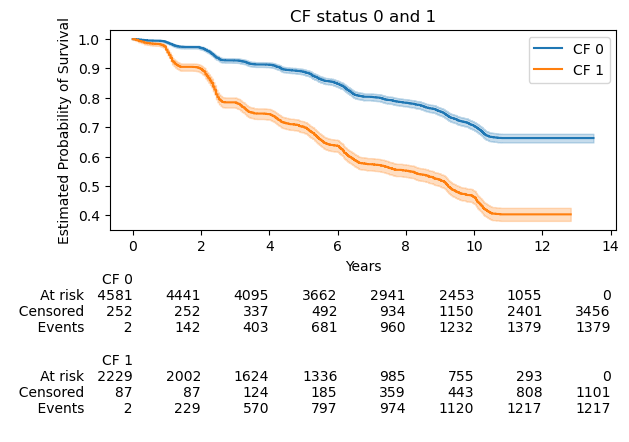

In [53]:
####CF Status  
CF_0 = data.init_CF==0      ## CF == 0 at wave 8
CF_1 = data.init_CF==1      ## CF == 1 at wave 8

a1 = plt.subplot(111)

## fit the model for GI I
kmf_0 = KaplanMeierFitter() ## instantiate the class to create an object
a1 = kmf_0.fit(data.time[CF_0], data.event[CF_0], label='CF 0').plot_survival_function(ax=a1)

## fit the model for GI II
kmf_1 = KaplanMeierFitter() ## instantiate the class to create an object
a1 = kmf_1.fit(data.time[CF_1], data.event[CF_1], label='CF 1').plot_survival_function(ax=a1)

# Add plot details
a1.set_title("CF status 0 and 1")
a1.set_ylabel("Estimated Probability of Survival")
a1.set_xlabel("Years")

# Add risk table
add_at_risk_counts(kmf_0, kmf_1, ax=a1)
plt.tight_layout()

kmf1_filepath = os.path.join(km_path, "KM_CF.png")
plt.savefig(kmf1_filepath)

# 3. Cox proportional hazard models of mortality

## 3.1. Prepare data

In [55]:
#define data for cox regression
data_cox = pd.DataFrame(data) 

#remove entries without an age
data_cox.dropna(subset=["age"], inplace=True)

print(data_cox.age.isna().value_counts())

#Controlling: age (standardized), female
data_cox["age_std"] = ( data_cox["age"] - data_cox["age"].mean() ) / data_cox["age"].std()
data_cox["age_std_squared"] = (data_cox["age"] - data_cox["age"].mean())**2 
data_cox["age_std_cubed"] = (data_cox["age"] - data_cox["age"].mean())**3


#######Experimental!!! I am binning the age variable
#data_cox["age_std"] = pd.cut(data_cox["age"], np.arange(data_cox["age"].min(), data_cox["age"].max(), 10))
#data_cox["age_std"] = pd.cut(data_cox["age"], np.arange(50, 110, 5))
#remove entries without an age
#data_cox.dropna(subset=["age_std"], inplace=True)

#data_cox["female2"] = -3
data_cox.loc[(data_cox.gender=="1.male"),'gender'] = 0
data_cox.loc[(data_cox.gender=="2.female"),'gender'] = 1
data_cox.rename(columns = {'gender':'female'}, inplace = True)
#data_cox.rename(columns = {'init_CF':'init_CF_1'}, inplace = True)

#Create dummy variables for GI I
data_cox["init_GI_I"] = 0
data_cox.loc[(data_cox.init_GI==1),'init_GI_I'] = 1
#Create dummy variables for GI II
data_cox["init_GI_II"] = 0
data_cox.loc[(data_cox.init_GI==2),'init_GI_II'] = 1
#Create dummy variables for GI III
data_cox["init_GI_III"] = 0
data_cox.loc[(data_cox.init_GI==3),'init_GI_III'] = 1
#Create dummy variables for GI IV
data_cox["init_GI_IV"] = 0
data_cox.loc[(data_cox.init_GI==4),'init_GI_IV'] = 1
#Create dummy variables for GI V
data_cox["init_GI_V"] = 0
data_cox.loc[(data_cox.init_GI==5),'init_GI_V'] = 1
#Create dummy variables for CF 1
data_cox["init_CF_1"] = 0
data_cox.loc[(data_cox.init_CF==1),'init_CF_1'] = 1

#Create severe variables
data_cox["init_GI_severe"] = 0
data_cox.loc[(data_cox.init_GI==4),'init_GI_severe'] = 1
data_cox.loc[(data_cox.init_GI==5),'init_GI_severe'] = 1

data_cox = data_cox[['init_GI_severe', 'init_GI', 'init_CF_1', 
                     'init_GI_I', 'init_GI_II', 'init_GI_III', 
                     'init_GI_IV', 'init_GI_V', 'fun_assess', 
                     'nrs_rhab', 'disrupt', 'freq_trans', 
                     'polypharm', 'event', 'time', 'age_std', 'age_std_squared', 'age_std_cubed', 
                     'female']] ###Remember to delete 'age_std_squared', 'age_std_cubed' if not used

data_cox_GI_CF = data_cox[['init_GI_II', 'init_GI_III', 
                           'init_GI_IV', 'init_GI_V', 'init_CF_1', 
                           'event', 'time', 'age_std', 'female']]
data_cox_GI_all = data_cox[['init_GI_II', 'init_GI_III', 
                            'init_GI_IV', 'init_GI_V', 'event', 
                            'time', 'age_std', 'female']]
data_cox_CF = data_cox[['init_CF_1', 'event', 'time', 'age_std', 
                        'female']]

data_cox_GI_I = data_cox[['init_GI_I', 'event', 'time', 'age_std', 
                          'female']]
data_cox_GI_II = data_cox[['init_GI_II', 'event', 'time', 'age_std', 
                           'female']]
data_cox_GI_III = data_cox[['init_GI_III', 'event', 'time', 'age_std', 
                            'female']]
data_cox_GI_IV = data_cox[['init_GI_IV', 'event', 'time', 'age_std', 
                           'female']]
data_cox_GI_V = data_cox[['init_GI_V', 'event', 'time', 'age_std', 
                          'female']]


age
False    7158
Name: count, dtype: int64


### 3.2. Model fitting 

#### GI II, GI III, GI IV, GI V, CF_1

<lifelines.CoxPHFitter: fitted with 7158 total observations, 4557 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 7158
number of events observed = 2601
   partial log-likelihood = -20675.79
         time fit was run = 2024-02-03 22:34:21 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
init_GI_II   -0.18       0.83       0.11            -0.40             0.04                 0.67                 1.04
init_GI_III   0.47       1.60       0.10             0.28             0.66                 1.33                 1.94
init_GI_IV    0.95       2.57       0.11             0.73             1.16                 2.08                 3.19
init_GI_V     1.08       2.95       0.10             0.88             1.28                 2.42                 3.60
init_CF_1     0.45       1.57       0.04             0.37             0.53                 1.44                 1.71
age_std       0.89       2.44       0.02             0.85             0.93                 2.34                 2.54
female       -0.36       0.69       0.04            -0.44            -0.29                 0.64                 0.75

              cmp to     z      p   -log2(p)
covariate                                   
init_GI_II      0.00 -1.64   0.10       3.29
init_GI_III     0.00  4.92 <0.005      20.14
init_GI_IV      0.00  8.62 <0.005      57.11
init_GI_V       0.00 10.70 <0.005      86.39
init_CF_1       0.00 10.43 <0.005      82.26
age_std         0.00 40.89 <0.005        inf
female          0.00 -9.22 <0.005      64.84
---
Concordance = 0.78
Partial AIC = 41365.59
log-likelihood ratio test = 2872.43 on 7 df
-log2(p) of ll-ratio test = inf

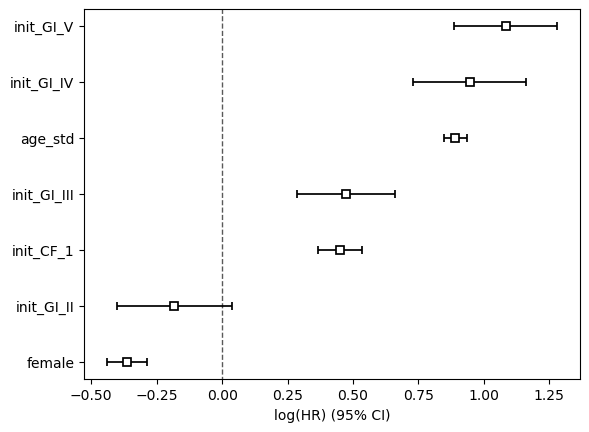

In [56]:
cphGI_CF = CoxPHFitter()
cphGI_CF.fit(data_cox_GI_CF, "time", event_col="event")
#cphGI_CF.fit(data_cox_GI_CF, "time", event_col="event", strata=["age_std"])
cphGI_CF.print_summary()
cphGI_CF.plot()

cph_filepath = os.path.join(cr_path, "CR_II_III_IV_V_CF.png")
plt.savefig(cph_filepath)

#### GI I

<lifelines.CoxPHFitter: fitted with 7158 total observations, 4557 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 7158
number of events observed = 2601
   partial log-likelihood = -21006.46
         time fit was run = 2024-02-03 22:34:22 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
init_GI_I  -0.64       0.53       0.09            -0.82            -0.46                 0.44                 0.63
age_std     0.96       2.60       0.02             0.91             1.00                 2.49                 2.72
female     -0.35       0.71       0.04            -0.42            -0.27                 0.65                 0.76

            cmp to     z      p   -log2(p)
covariate                                 
init_GI_I     0.00 -6.84 <0.005      36.86
age_std       0.00 43.32 <0.005        inf
female        0.00 -8.83 <0.005      59.72
---
Concordance = 0.74
Partial AIC = 42018.93
log-likelihood ratio test = 2211.09 on 3 df
-log2(p) of ll-ratio test = inf

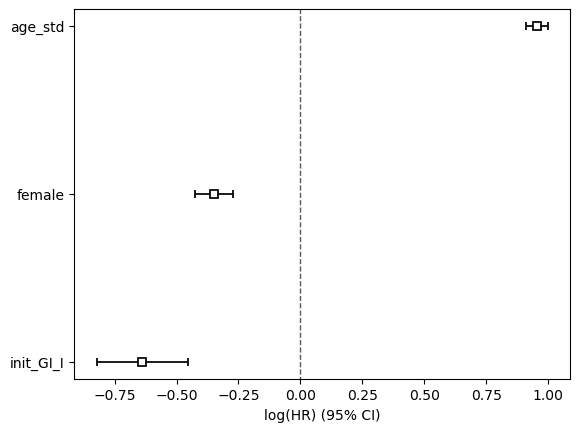

In [57]:
cphGI_I = CoxPHFitter()
cphGI_I.fit(data_cox_GI_I, "time", event_col="event")
cphGI_I.print_summary()
cphGI_I.plot()

cph_filepath = os.path.join(cr_path, "CR_I.png")
plt.savefig(cph_filepath)

#### GI II

<lifelines.CoxPHFitter: fitted with 7158 total observations, 4557 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 7158
number of events observed = 2601
   partial log-likelihood = -20915.24
         time fit was run = 2024-02-03 22:34:23 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
init_GI_II  -0.93       0.39       0.07            -1.06            -0.80                 0.34                 0.45
age_std      0.95       2.59       0.02             0.91             1.00                 2.49                 2.71
female      -0.30       0.74       0.04            -0.38            -0.23                 0.68                 0.80

             cmp to      z      p   -log2(p)
covariate                                   
init_GI_II     0.00 -13.66 <0.005     138.77
age_std        0.00  43.95 <0.005        inf
female         0.00  -7.72 <0.005      46.28
---
Concordance = 0.75
Partial AIC = 41836.48
log-likelihood ratio test = 2393.54 on 3 df
-log2(p) of ll-ratio test = inf

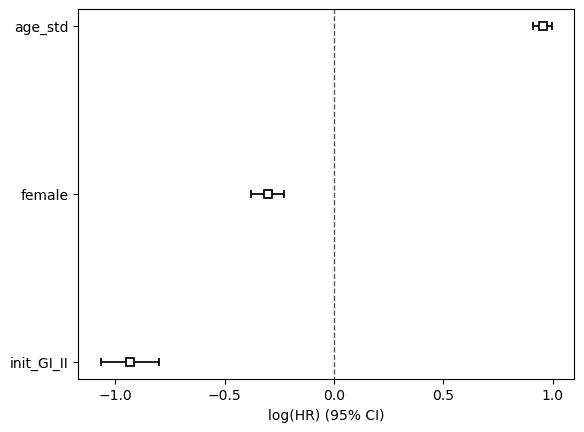

In [58]:
cphGI_II = CoxPHFitter()
cphGI_II.fit(data_cox_GI_II, "time", event_col="event")
cphGI_II.print_summary()
cphGI_II.plot()

cph_filepath = os.path.join(cr_path, "CR_II.png")
plt.savefig(cph_filepath)

#### GI III

<lifelines.CoxPHFitter: fitted with 7158 total observations, 4557 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 7158
number of events observed = 2601
   partial log-likelihood = -21026.86
         time fit was run = 2024-02-03 22:34:23 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
init_GI_III  -0.16       0.85       0.04            -0.23            -0.08                 0.79                 0.92
age_std       0.98       2.66       0.02             0.94             1.02                 2.55                 2.78
female       -0.34       0.71       0.04            -0.42            -0.26                 0.66                 0.77

              cmp to     z      p   -log2(p)
covariate                                   
init_GI_III     0.00 -3.98 <0.005      13.81
age_std         0.00 45.18 <0.005        inf
female          0.00 -8.68 <0.005      57.83
---
Concordance = 0.74
Partial AIC = 42059.72
log-likelihood ratio test = 2170.30 on 3 df
-log2(p) of ll-ratio test = inf

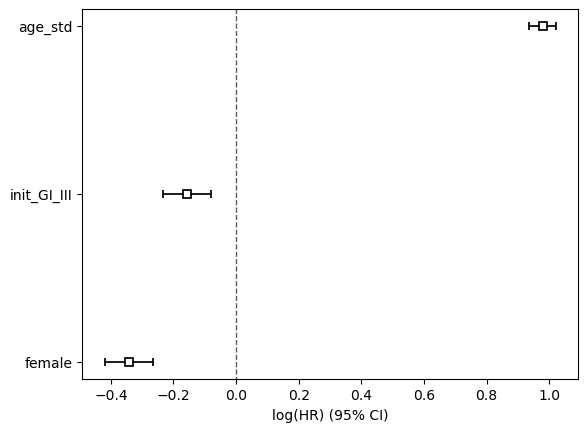

In [59]:
cphGI_III = CoxPHFitter()
cphGI_III.fit(data_cox_GI_III, "time", event_col="event")
cphGI_III.print_summary()
cphGI_III.plot()

cph_filepath = os.path.join(cr_path, "CR_III.png")
plt.savefig(cph_filepath)

#### GI IV

<lifelines.CoxPHFitter: fitted with 7158 total observations, 4557 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 7158
number of events observed = 2601
   partial log-likelihood = -21009.15
         time fit was run = 2024-02-03 22:34:24 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
init_GI_IV   0.47       1.61       0.06             0.35             0.60                 1.42                 1.81
age_std      0.97       2.63       0.02             0.93             1.01                 2.52                 2.75
female      -0.34       0.72       0.04            -0.41            -0.26                 0.66                 0.77

             cmp to     z      p   -log2(p)
covariate                                  
init_GI_IV     0.00  7.60 <0.005      44.98
age_std        0.00 44.86 <0.005        inf
female         0.00 -8.53 <0.005      55.90
---
Concordance = 0.74
Partial AIC = 42024.31
log-likelihood ratio test = 2205.71 on 3 df
-log2(p) of ll-ratio test = inf

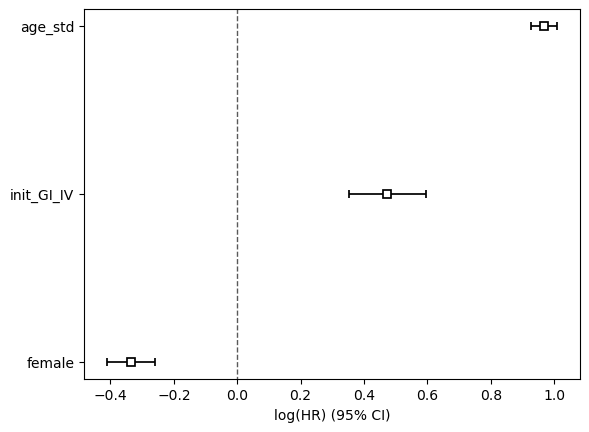

In [60]:
cphGI_IV = CoxPHFitter()
cphGI_IV.fit(data_cox_GI_IV, "time", event_col="event")
cphGI_IV.print_summary()
cphGI_IV.plot()

cph_filepath = os.path.join(cr_path, "CR_IV.png")
plt.savefig(cph_filepath)

#### GI V

<lifelines.CoxPHFitter: fitted with 7158 total observations, 4557 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 7158
number of events observed = 2601
   partial log-likelihood = -20854.41
         time fit was run = 2024-02-03 22:34:25 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
init_GI_V   0.87       2.39       0.04             0.79             0.96                 2.20                 2.60
age_std     0.93       2.54       0.02             0.89             0.98                 2.44                 2.66
female     -0.35       0.71       0.04            -0.42            -0.27                 0.65                 0.76

            cmp to     z      p   -log2(p)
covariate                                 
init_GI_V     0.00 20.22 <0.005     299.50
age_std       0.00 42.61 <0.005        inf
female        0.00 -8.81 <0.005      59.50
---
Concordance = 0.76
Partial AIC = 41714.81
log-likelihood ratio test = 2515.21 on 3 df
-log2(p) of ll-ratio test = inf

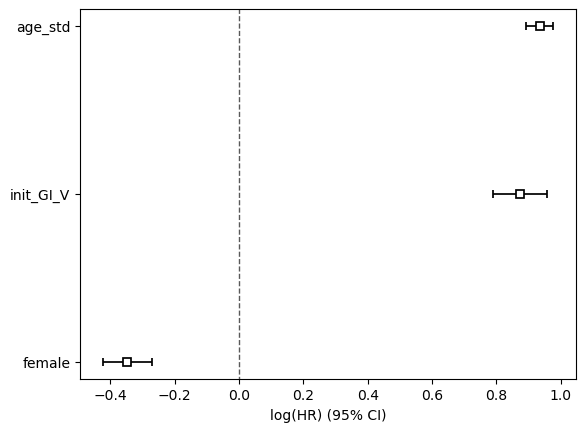

In [61]:
cphGI_V = CoxPHFitter()
cphGI_V.fit(data_cox_GI_V, "time", event_col="event")
cphGI_V.print_summary()
cphGI_V.plot()

cph_filepath = os.path.join(cr_path, "CR_V.png")
plt.savefig(cph_filepath)

#### CF

<lifelines.CoxPHFitter: fitted with 7158 total observations, 4557 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 7158
number of events observed = 2601
   partial log-likelihood = -20862.27
         time fit was run = 2024-02-03 22:34:25 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
init_CF_1   0.75       2.13       0.04             0.68             0.83                 1.97                 2.30
age_std     0.94       2.56       0.02             0.90             0.98                 2.45                 2.67
female     -0.39       0.68       0.04            -0.47            -0.31                 0.63                 0.73

            cmp to     z      p   -log2(p)
covariate                                 
init_CF_1     0.00 18.92 <0.005     262.72
age_std       0.00 43.40 <0.005        inf
female        0.00 -9.84 <0.005      73.52
---
Concordance = 0.76
Partial AIC = 41730.54
log-likelihood ratio test = 2499.48 on 3 df
-log2(p) of ll-ratio test = inf

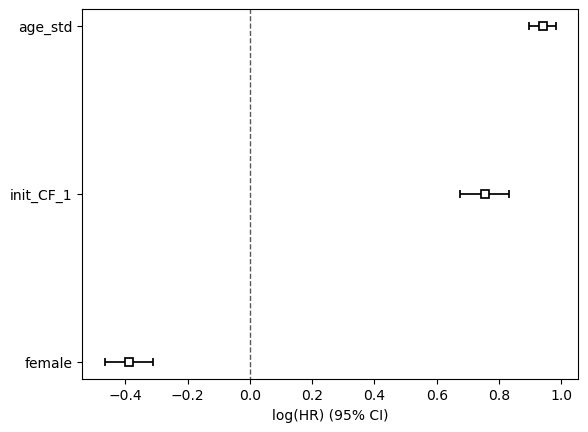

In [62]:
cphCF = CoxPHFitter()
cphCF.fit(data_cox_CF, "time", event_col="event")
cphCF.print_summary()
cphCF.plot()

cph_filepath = os.path.join(cr_path, "CR_CF.png")
plt.savefig(cph_filepath)